# Climate variability Davies Reef

In [1]:
import os
import scipy
import numpy as np
import pandas as pd

import io
import requests

import datetime as dt
from dateutil.relativedelta import *

import netCDF4
from netCDF4 import Dataset, num2date

import cmocean

import seaborn as sns
import pymannkendall as mk

from matplotlib import pyplot as plt
# %config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (12,7)
plt.ion()  # To trigger the interactive inline mode

In this notebook, we use OpeNDAP to extract time series data at a single location of interest, then plot this data and evaluate climate variability based on long term trend and ENSO oscillations.

## Connect to the OpeNDAP server to extract dataset from multiple files 

We query the server based on the OPeNDAP URL for a specific file "EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-YYYY-MM.nc". 


- **gbr4**: we use the Hydrodynamic 4km model and daily data for the month specified


Like for our previous example we will use Davies Reef:

In [2]:
site_lat = -18.82
site_lon = 147.64

We will use the available parameters from the eReefs dataset at the surface. This is done by defining the required depth index. For the GBR4 model this index is 16.

In [3]:
selectedDepthIndex = 16 # corresponding to -0.5 m

Checking from **AIMS thredds server**:
    
+  [Dataset THREDDS](http://thredds.ereefs.aims.gov.au/thredds/s3catalogue/aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/catalog.html)

The data are archived monthly from September 2010 to present.

In [4]:
def find_nearest(array, value):
    '''
    Find index of nearest value in a numpy array
    '''
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    return idx

To collect iteratively the information from each file we perform a while loop. 

**This cell takes a lot of time to run.** 

To speed up the process you might want to only extract the information for a restricted period of time and also some specific parameters (*e.g.* temperature or current speed...).

For the sake of the exercise, I have stored the output from this cell in a CSV file (`DaviesReef_timeseries.csv`) so there is no need to run it again! Obviously depending of the reef you will chose in your project, you will need to run it.

In [5]:
# # Define starting and ending date of the netcdf file we want to load 
# start_date = dt.date(2010, 9, 1)
# end_date = dt.date(2021, 2, 1)
# delta = relativedelta(months=+1)

# # Now perform a while loop to open the netcdf file and extract the relevant dataset for the site of interest
# step = True
# while start_date <= end_date:
    
#     # Read individual file from the OpeNDAP server
#     netCDF_datestr = str(start_date.year)+'-'+format(start_date.month, '02')
#     print('Processing time interval:',netCDF_datestr)
#     inputFile = "http://thredds.ereefs.aims.gov.au/thredds/dodsC/s3://aims-ereefs-public-prod/derived/ncaggregate/ereefs/gbr4_v2/daily-monthly/EREEFS_AIMS-CSIRO_gbr4_v2_hydro_daily-monthly-"+netCDF_datestr+".nc"
#     start_date += delta    
#     nc_data = Dataset(inputFile, 'r')
#     ncdata = nc_data.variables
    
#     # Get parameters values for each single file
#     if step:
#         lat = ncdata['latitude'][:].filled(fill_value=0.)
#         lon = ncdata['longitude'][:].filled(fill_value=0.)
#         times = ncdata['time'][:]
#         selectedLatIndex = find_nearest(lat,site_lat)
#         selectedLonIndex = find_nearest(lon,site_lon)
#         current = nc_data.variables['mean_cur'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
#         wind = nc_data.variables['mean_wspeed'][:, selectedLatIndex, selectedLonIndex]
#         temperature = nc_data.variables['temp'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
#         salinity = nc_data.variables['salt'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
#     else:
#         days = ncdata['time'][:]
#         times = np.hstack((times,days))
#         dailyCurr = nc_data.variables['mean_cur'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
#         current = np.hstack((current,dailyCurr))
#         dailyWind = nc_data.variables['mean_wspeed'][:, selectedLatIndex, selectedLonIndex]
#         wind = np.hstack((wind,dailyWind))
#         dailyTemp = nc_data.variables['temp'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
#         temperature = np.hstack((temperature,dailyTemp))
#         dailySalt = nc_data.variables['salt'][:,selectedDepthIndex, selectedLatIndex, selectedLonIndex]
#         salinity = np.hstack((salinity,dailySalt))
#     step = False


# time = pd.to_datetime(times[:],unit='D',origin=pd.Timestamp('1990-01-01'))

# # Create a pandas dataframe containing the information from all the files
# df = pd.DataFrame(
#     data={
#         "date": time,
#         "current": current,
#         "wind": wind,
#         "salinity": salinity,
#         "temperature": temperature,
#     }
# )

# # Store these informations on a file in case you want to reuse them later on without having to 
# # rerun this cell...
# df.to_csv(
#         "DaviesReef_timeseries.csv",
#         columns=["date", "current", "wind", "salinity", "temperature"],
#         sep=" ",
#         index=False,
#         header=1,
#     )

Let's read the saved CSV file:

In [6]:
df = pd.read_csv(
        "DaviesReef_timeseries.csv",
        sep=r"\s+",
        engine="c",
        header=0,
        na_filter=False,
        low_memory=False,
    )
df['date']= pd.to_datetime(df['date'])

We can visualise the file content in the Jupyter environment by simply calling the dataframe `df`:

In [7]:
df

,date,current,wind,salinity,temperature
0,2010-09-01,0.188395,7.481102,35.473610,25.177170
1,2010-09-02,0.286188,4.995992,35.485250,25.262072
2,2010-09-03,0.293674,6.024843,35.462696,25.201515
3,2010-09-04,0.285468,5.704914,35.441630,25.385157
4,2010-09-05,0.340165,4.365893,35.412930,25.719600
...,...,...,...,...,...
3810,2021-02-05,0.277080,4.445975,34.718620,29.459562
3811,2021-02-06,0.260329,4.586412,34.714035,29.594269
3812,2021-02-07,0.314890,3.947094,34.716280,29.515007
3813,2021-02-08,0.310675,3.053977,34.704310,29.504288


What we have here are the outputs from the eReefs model for the closest point to our location (Davies Reef in this example).


## Computing eReefs outputs seasonality


### Time series

We will first explore over time the evolution of the parameters by plotting **time series**. We will plot the raw data as well as the rolling mean value for a considered window (here we pick 30 days corresponding to a monthly mean).

In addition to the time series, we will also compute  additional information:
+ Maximum parameter value
+ Mean parameter value
+ Median parameter value
+ 95th percentile parameter value

In [8]:
# Number of observations used for calculating the mean 
days = int(30)

# Compute the rolling window for the mean
rolling = df.rolling(str(days) + "D", on="date", min_periods=1).mean()

current_roll = rolling["current"]
wind_roll = rolling["wind"]
salinity_roll = rolling["salinity"]
temperature_roll = rolling["temperature"]

# Let us store these means in a new datafame
timeseries = pd.DataFrame(
            data={
                "date": df['date'],
                "current": df['current'],
                "current_roll": current_roll,
                "wind": df['wind'],
                "wind_roll": wind_roll,
                "salinity": df['salinity'],
                "salinity_roll": salinity_roll,
                "temperature": df['temperature'],
                "temperature_roll": temperature_roll,
            }
        )

timeseries["day"] = timeseries["date"].dt.day
timeseries["month"] = timeseries["date"].dt.month
timeseries["year"] = timeseries["date"].dt.year

# Let's open the new dataframe
timeseries

,date,current,current_roll,wind,wind_roll,salinity,salinity_roll,temperature,temperature_roll,day,month,year
0,2010-09-01,0.188395,0.188395,7.481102,7.481102,35.473610,35.473610,25.177170,25.177170,1,9,2010
1,2010-09-02,0.286188,0.237291,4.995992,6.238547,35.485250,35.479430,25.262072,25.219621,2,9,2010
2,2010-09-03,0.293674,0.256086,6.024843,6.167312,35.462696,35.473852,25.201515,25.213586,3,9,2010
3,2010-09-04,0.285468,0.263431,5.704914,6.051713,35.441630,35.465797,25.385157,25.256479,4,9,2010
4,2010-09-05,0.340165,0.278778,4.365893,5.714549,35.412930,35.455223,25.719600,25.349103,5,9,2010
...,...,...,...,...,...,...,...,...,...,...,...,...
3810,2021-02-05,0.277080,0.277039,4.445975,6.971252,34.718620,34.481060,29.459562,28.565893,5,2,2021
3811,2021-02-06,0.260329,0.272052,4.586412,6.993279,34.714035,34.518746,29.594269,28.582697,6,2,2021
3812,2021-02-07,0.314890,0.269493,3.947094,7.023985,34.716280,34.561972,29.515007,28.590874,7,2,2021
3813,2021-02-08,0.310675,0.271852,3.053977,6.975869,34.704310,34.602364,29.504288,28.602725,8,2,2021


We can now plot the time series based on the above dataset. 

### Mean current time series at site location

This is done like this:

Max surface current: 0.817 m/s
Mean surface current: 0.266 m/s
Median surface current: 0.257 m/s
95th percentile mean current: 0.422 m/s


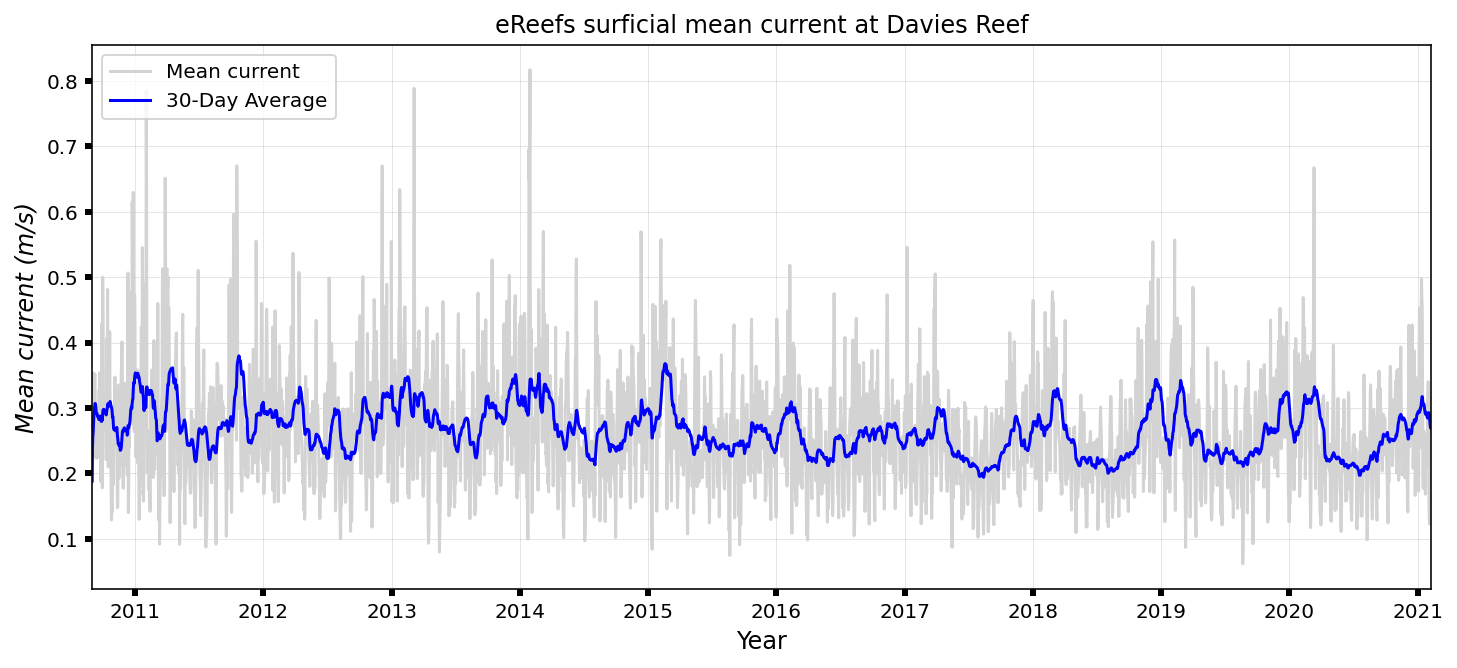

In [9]:
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(timeseries.date, timeseries.current, color="lightgrey", label="Mean current")
ax1.plot(
    timeseries.date,
    timeseries.current_roll,
    color="blue",
    label=str(days) + "-Day Average",
)
ax1.legend(
    labels=["Mean current", str(days) + "-Day Average"],
    loc="upper left",
)
ax1.set_ylabel("Mean current (m/s)", style="italic", fontsize=12)
print("Max surface current: {:0.3f} m/s".format(max(timeseries.current)))
print("Mean surface current: {:0.3f} m/s".format(np.mean(timeseries.current)))
print("Median surface current: {:0.3f} m/s".format(np.median(timeseries.current)))
print(
    "95th percentile mean current: {:0.3f} m/s".format(
        np.percentile(timeseries.current, 95)
    )
)
ax1.set_xlim(min(timeseries.date), max(timeseries.date))
ax1.set_xlabel("Year", fontsize=12)
ax1.grid(True, linewidth=0.5, color="k", alpha=0.1, linestyle="-")
ax1.tick_params(labelcolor="k", labelsize="medium", width=3)
plt.title('eReefs surficial mean current at Davies Reef')
plt.show()
#fig.savefig("DaviesReefcurrentVariability", dpi=100)

Same goes with the other parameters:

Max mean wind: 18.901 m/s
Mean mean wind: 6.708 m/s
Median mean wind: 6.528 m/s
95th percentile mean wind: 11.202 m/s


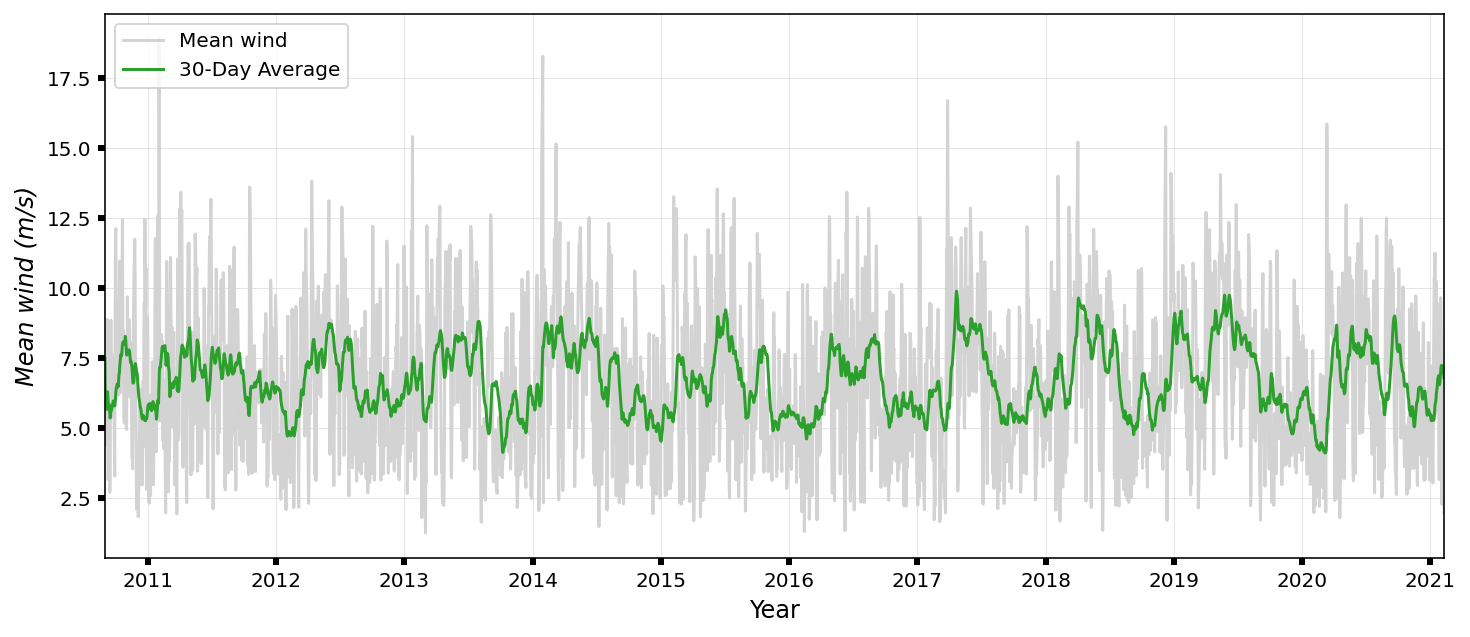

Max surface temperature: 31.599 deg. C
Mean surface temperature: 26.610 deg. C
Median surface temperature: 26.700 deg. C
95th percentile mean surface temperature: 29.628 deg. C


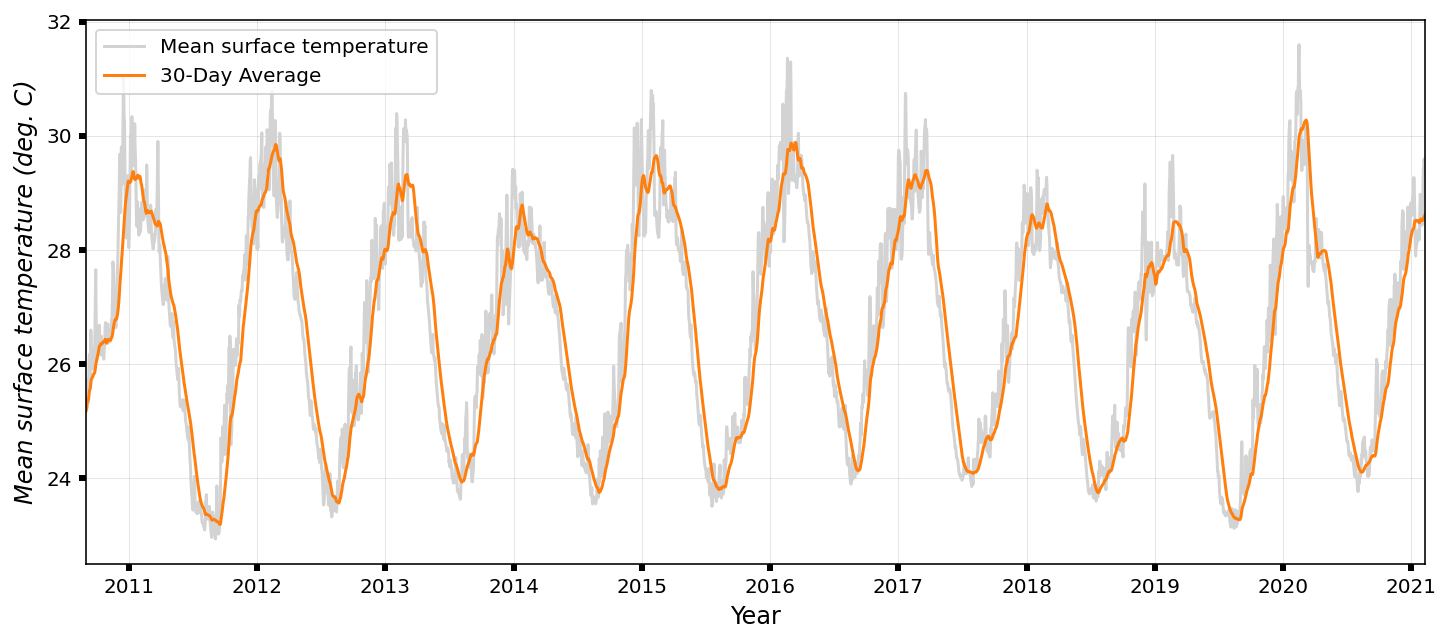

Max surface salinity: 35.764 PSU
Mean surface salinity: 35.182 PSU
Median surface salinity: 35.263 PSU
95th percentile mean surface salinity: 35.501 PSU


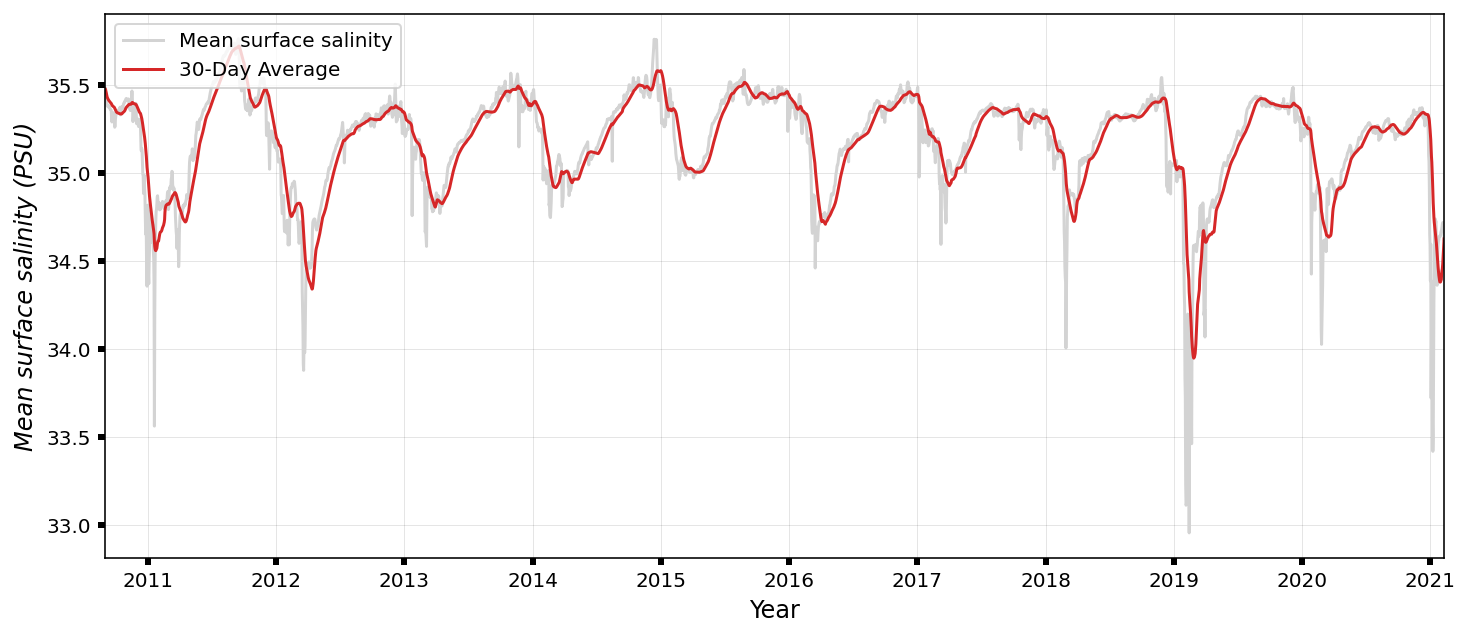

In [10]:
### WIND
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(timeseries.date, timeseries.wind, color="lightgrey", label="Mean wind")
ax1.plot(
    timeseries.date,
    timeseries.wind_roll,
    color="tab:green",
    label=str(days) + "-Day Average",
)
ax1.legend(
    labels=["Mean wind", str(days) + "-Day Average"],
    loc="upper left",
)
ax1.set_ylabel("Mean wind (m/s)", style="italic", fontsize=12)
print("Max mean wind: {:0.3f} m/s".format(max(timeseries.wind)))
print("Mean mean wind: {:0.3f} m/s".format(np.mean(timeseries.wind)))
print("Median mean wind: {:0.3f} m/s".format(np.median(timeseries.wind)))
print(
    "95th percentile mean wind: {:0.3f} m/s".format(
        np.percentile(timeseries.wind, 95)
    )
)
ax1.set_xlim(min(timeseries.date), max(timeseries.date))
ax1.set_xlabel("Year", fontsize=12)
ax1.grid(True, linewidth=0.5, color="k", alpha=0.1, linestyle="-")
ax1.tick_params(labelcolor="k", labelsize="medium", width=3)
plt.show()

### TEMPERATURE
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(timeseries.date, timeseries.temperature, color="lightgrey", label="Mean wind")
ax1.plot(
    timeseries.date,
    timeseries.temperature_roll,
    color="tab:orange",
    label=str(days) + "-Day Average",
)
ax1.legend(
    labels=["Mean surface temperature", str(days) + "-Day Average"],
    loc="upper left",
)
ax1.set_ylabel("Mean surface temperature (deg. C)", style="italic", fontsize=12)
print("Max surface temperature: {:0.3f} deg. C".format(max(timeseries.temperature)))
print("Mean surface temperature: {:0.3f} deg. C".format(np.mean(timeseries.temperature)))
print("Median surface temperature: {:0.3f} deg. C".format(np.median(timeseries.temperature)))
print(
    "95th percentile mean surface temperature: {:0.3f} deg. C".format(
        np.percentile(timeseries.temperature, 95)
    )
)
ax1.set_xlim(min(timeseries.date), max(timeseries.date))
ax1.set_xlabel("Year", fontsize=12)
ax1.grid(True, linewidth=0.5, color="k", alpha=0.1, linestyle="-")
ax1.tick_params(labelcolor="k", labelsize="medium", width=3)
plt.show()

### SALINITY
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(timeseries.date, timeseries.salinity, color="lightgrey", label="Mean wind")
ax1.plot(
    timeseries.date,
    timeseries.salinity_roll,
    color="tab:red",
    label=str(days) + "-Day Average",
)
ax1.legend(
    labels=["Mean surface salinity", str(days) + "-Day Average"],
    loc="upper left",
)
ax1.set_ylabel("Mean surface salinity (PSU)", style="italic", fontsize=12)
print("Max surface salinity: {:0.3f} PSU".format(max(timeseries.salinity)))
print("Mean surface salinity: {:0.3f} PSU".format(np.mean(timeseries.salinity)))
print("Median surface salinity: {:0.3f} PSU".format(np.median(timeseries.salinity)))
print(
    "95th percentile mean surface salinity: {:0.3f} PSU".format(
        np.percentile(timeseries.salinity, 95)
    )
)
ax1.set_xlim(min(timeseries.date), max(timeseries.date))
ax1.set_xlabel("Year", fontsize=12)
ax1.grid(True, linewidth=0.5, color="k", alpha=0.1, linestyle="-")
ax1.tick_params(labelcolor="k", labelsize="medium", width=3)
plt.show()

### Seasonability trends

In addition to time series, we can analyse the seasonal characteristics of eReefs parameters.

To do that we first need to group the previous data frame by month. We define a function `getSeason` that can be called for each parameter:

In [11]:
def getSeason(param):
    tdf = (timeseries.groupby(["year", "month"])[[param]]
                    .apply(np.mean)
                    .reset_index()
        )

    dfseason = tdf.pivot(index="year", columns="month", values=param)

    dfseason = dfseason.rename(
        columns={
            1: "January",
            2: "February",
            3: "March",
            4: "April",
            5: "May",
            6: "June",
            7: "July",
            8: "August",
            9: "September",
            10: "October",
            11: "November",
            12: "December",
        }
    )

    return dfseason

# Let's call the function
Current_season = getSeason('current')
Wind_season = getSeason('wind')
Temp_season = getSeason('temperature')
Salt_season = getSeason('salinity')

### Heatmaps

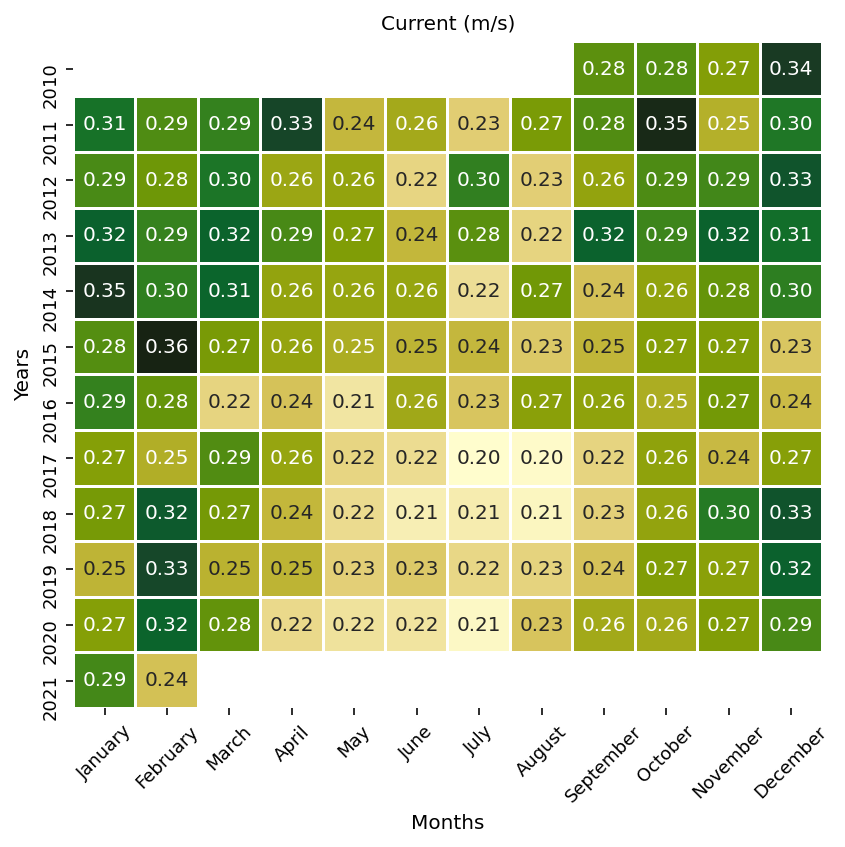

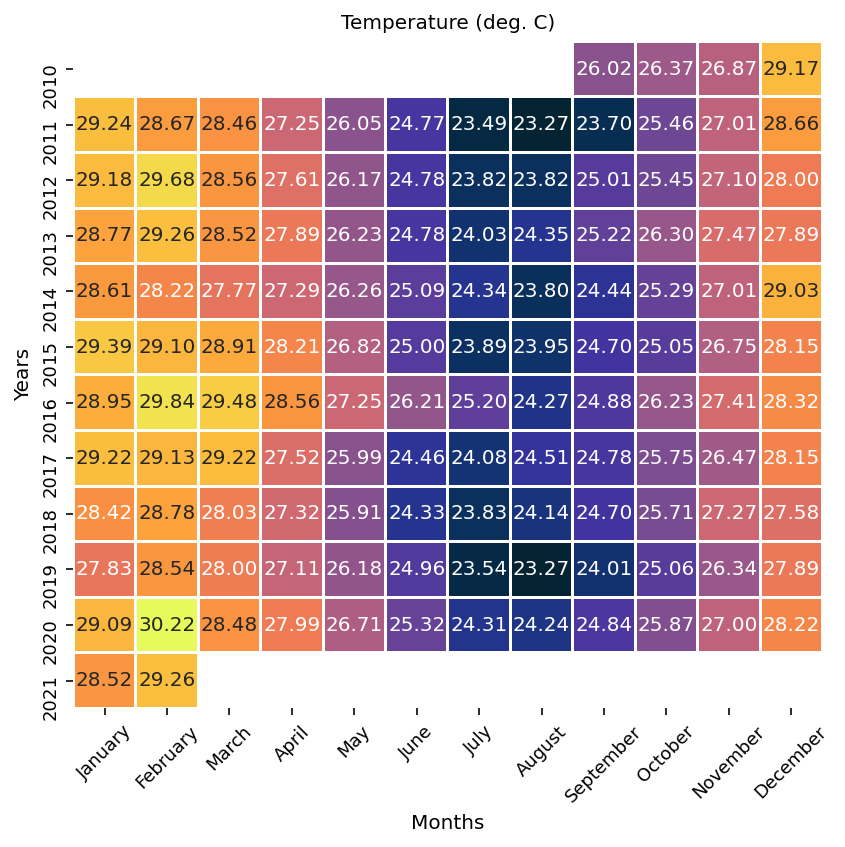

In [15]:
# Current
color = cmocean.cm.speed
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(
    Current_season, annot=True, fmt=".2f", cmap=color, linewidths=1, cbar=False
)
ax.set_title("Current (m/s)", fontsize=10)
ax.set_ylabel("Years", fontsize=10)
ax.set_xlabel("Months", fontsize=10)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plt.tight_layout()
plt.show()

# Temperature
color = cmocean.cm.thermal
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(
    Temp_season, annot=True, fmt=".2f", cmap=color, linewidths=1, cbar=False
)
ax.set_title("Temperature (deg. C)", fontsize=10)
ax.set_ylabel("Years", fontsize=10)
ax.set_xlabel("Months", fontsize=10)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plt.tight_layout()
plt.show()

### Monthly distributions

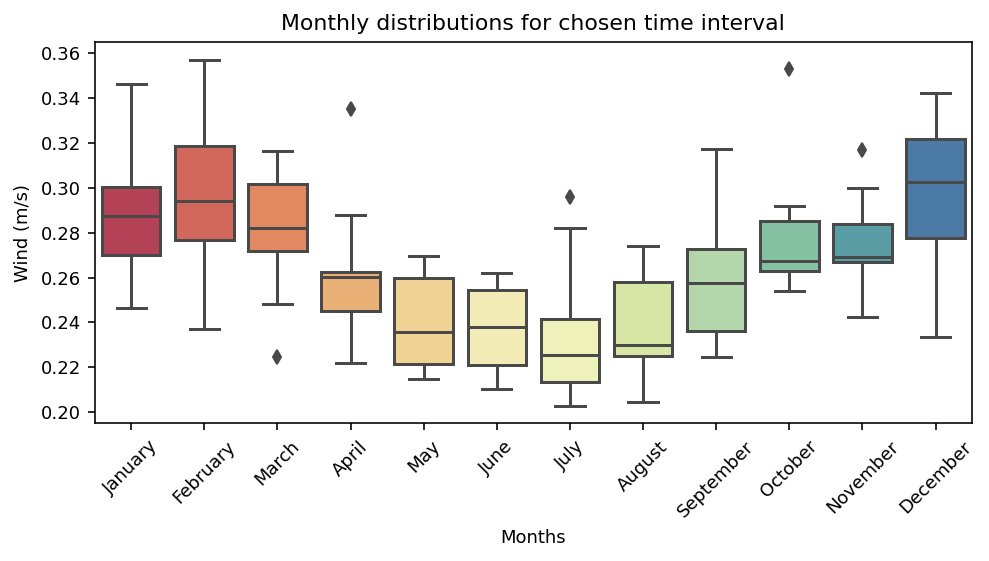

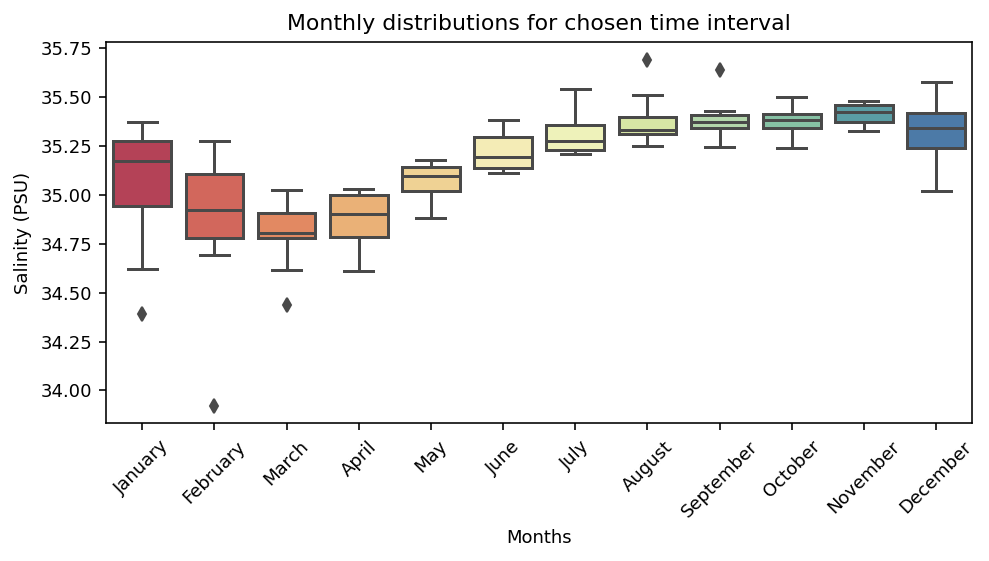

In [13]:
# Wind
fig, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(data=Current_season, palette="Spectral")
ax.set_title("Monthly distributions for chosen time interval", fontsize=11)
ax.set_ylabel("Wind (m/s)", fontsize=9)
ax.set_xlabel("Months", fontsize=9)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plt.tight_layout()
plt.show()

# Salinity
fig, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(data=Salt_season, palette="Spectral")
ax.set_title("Monthly distributions for chosen time interval", fontsize=11)
ax.set_ylabel("Salinity (PSU)", fontsize=9)
ax.set_xlabel("Months", fontsize=9)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plt.tight_layout()
plt.show()

### Standard deviation to the mean by months

In [ ]:
curr_sd = Current_season.std(axis=0)
wind_sd = Wind_season.std(axis=0)
temp_sd = Temp_season.std(axis=0)
salt_sd = Salt_season.std(axis=0)

# Make figure
fig, ax = plt.subplots(figsize=(8, 4))

curr_sd.plot(marker="o", linestyle="dashed", linewidth=1, markersize=9, label='curr')
wind_sd.plot(marker="o", linestyle="dashed", linewidth=1, markersize=9, label='wind')
temp_sd.plot(marker="o", linestyle="dashed", linewidth=1, markersize=9, label='temp')
salt_sd.plot(marker="o", linestyle="dashed", linewidth=1, markersize=9, label='salt')

ax.set_title("Standard deviation in Davies Reef for chosen time interval",fontsize=11)
ax.set_ylabel("Standard deviation", fontsize=10)
ax.set_xlabel("Months", fontsize=10)
ax.yaxis.set_tick_params(labelsize=9)
ax.xaxis.set_tick_params(labelsize=9, rotation=45)
plt.legend() #loc='upper right', bbox_to_anchor=(0.91, 0.91))
plt.tight_layout()
plt.show()

Analysing the trend:

In [ ]:
curr_stack = Current_season.stack()
curr_trend = mk.seasonal_test(curr_stack, period=12)
print(" ")
print("Change in yearly current trend accounting for seasonality:")
print("    +           trend: ", curr_trend.trend)
print("    +    slope (cm/s /y): ",str(round(curr_trend.slope * 100.0, 2)))

wind_stack = Wind_season.stack()
wind_trend = mk.seasonal_test(wind_stack, period=12)
print(" ")
print("Change in yearly wind trend accounting for seasonality:")
print("    +           trend: ", wind_trend.trend)
print("    +    slope (cm/s /y): ",str(round(wind_trend.slope * 100.0, 2)))

temp_stack = Temp_season.stack()
temp_trend = mk.seasonal_test(temp_stack, period=12)
print(" ")
print("Change in yearly temperature trend accounting for seasonality:")
print("    +           trend: ", temp_trend.trend)
print("    +    slope (deg. C /y): ",str(round(temp_trend.slope, 2)))

salt_stack = Salt_season.stack()
salt_trend = mk.seasonal_test(salt_stack, period=12)
print(" ")
print("Change in yearly salinity trend accounting for seasonality:")
print("    +           trend: ", salt_trend.trend)
print("    +    slope (PSU /y): ",str(round(salt_trend.slope, 2)))

## Multi-years analysis of the impact of climate trend 

Oscillation in atmospheric patterns is known to alter regional weather conditions and associated trends in wave climate [Godoi et al., 2016].

Here we illustrate how the results obtained with **eReefs** can be used to investigate how climate patterns may affect different hydrodynamic parameters.

For the sake of the demonstration, we will focus our analysis on the following indices:

+ SOI - Southern Oscillation Index / [information](http://www.bom.gov.au/climate/enso/history/ln-2010-12/SOI-what.shtml)

We first load the data associated to each index using `Pandas` functionalities.

+ Godoi, V.A., Bryan, K.R. and Gorman, R.M., 2016. [Regional influence of climate patterns on the wave climate of the southwestern Pacific: The New Zealand region](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1002/2015JC011572). Journal of Geophysical Research: Oceans, 121(6), pp.4056-4076.

In [ ]:
# Defining the timeframe
time = [2011,2020] 

Monthly means of the SOI index are sourced from the National Oceanic and Atmospheric Administration (**NOAA**) and the Natural Environment Research Council from the British Antarctic Survey (**NERC**). 

The anomalies are computed by subtracting overall mean from the monthly means. 

Then, the same is done for the eReefs parameters in order to investigate how they are modulated by the climate modes.


### SOI - Southern Oscillation Index

In [ ]:
# Dataset URL
url = "https://www.ncdc.noaa.gov/teleconnections/enso/indicators/soi/data.csv"

# Using Pandas to load the file content
soi = requests.get(url).content
soi_data = pd.read_csv(io.StringIO(soi.decode('utf-8')),skiprows=1)

# Define year and month of each record
soi_data['year'] = soi_data['Date'] // 100
soi_data['month'] = soi_data['Date'] % 100 

# Extract the information for the specified time interval 
soi_df = soi_data.drop(soi_data[soi_data.year < time[0]].index)
soi_df = soi_df.drop(soi_df[soi_df.year > time[1]].index)

# Calculate the 20-years mean 
soi_mean = soi_df['Value'].mean()

# Compute and store the anomalies in the dataframe
soi_df['anomaly'] = soi_df['Value']-soi_mean

soi_df

eReefs outputs anomalies:

In [ ]:
# Get monthly mean eReefs parameters
curr_data = timeseries.groupby(['year', 'month'])[['current']].apply(np.mean).reset_index()
wind_data = timeseries.groupby(['year', 'month'])[['wind']].apply(np.mean).reset_index()
temp_data = timeseries.groupby(['year', 'month'])[['temperature']].apply(np.mean).reset_index()
salt_data = timeseries.groupby(['year', 'month'])[['salinity']].apply(np.mean).reset_index()

# Extract the information for the specified time interval 
curr_df = curr_data.drop(curr_data[curr_data.year < time[0]].index)
curr_df = curr_df.drop(curr_df[curr_df.year > time[1]].index)
wind_df = wind_data.drop(wind_data[wind_data.year < time[0]].index)
wind_df = wind_df.drop(wind_df[wind_df.year > time[1]].index)
temp_df = temp_data.drop(temp_data[temp_data.year < time[0]].index)
temp_df = temp_df.drop(temp_df[temp_df.year > time[1]].index)
salt_df = salt_data.drop(salt_data[salt_data.year < time[0]].index)
salt_df = salt_df.drop(salt_df[salt_df.year > time[1]].index)

# Calculate the mean 
curr_mean = curr_df['current'].mean()
wind_mean = wind_df['wind'].mean()
temp_mean = temp_df['temperature'].mean()
salt_mean = salt_df['salinity'].mean()

# Compute and store the anomalies in the dataframe
curr_df['anomaly'] = curr_df['current']-curr_mean
wind_df['anomaly'] = wind_df['wind']-wind_mean
temp_df['anomaly'] = temp_df['temperature']-temp_mean
salt_df['anomaly'] = salt_df['salinity']-salt_mean

### Correlations

Monthly mean anomalies of eReefs outputs can be correlated with monthly mean anomaly time series of the SOI index by computing the **Pearson’s correlation coefficient** (R) for the region of interest. 

We use [scipy.stats.pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) function to make this calculation. This function returns 2 values:

+ r: Pearson’s correlation coefficient.
+ p: Two-tailed p-value.

In [ ]:
# Pearson correlation between current and SOI
monthly_soi = scipy.stats.pearsonr(soi_df['anomaly'],curr_df['anomaly']) 
print('+ Pearson correlation between current and SOI:',monthly_soi[0],'\n')

# Pearson correlation between wind and SOI
monthly_soi = scipy.stats.pearsonr(soi_df['anomaly'],wind_df['anomaly']) 
print('+ Pearson correlation between wind and SOI:',monthly_soi[0],'\n')

# Pearson correlation between temperature and SOI
monthly_curr_soi = scipy.stats.pearsonr(soi_df['anomaly'],temp_df['anomaly']) 
print('+ Pearson correlation between temperature and SOI:',monthly_soi[0],'\n')

# Pearson correlation between salinity and SOI
monthly_soi = scipy.stats.pearsonr(soi_df['anomaly'],salt_df['anomaly']) 
print('+ Pearson correlation between salinity and SOI:',monthly_soi[0],'\n')